# Exploratory Data Analysis + Error Analysis

This notebook houses the exploratory analysis of the **default** variant of the **mt5-small-thai-multiple-e2e-qg** family since it is generally the best in real-world performance.


# Install requirements


In [ ]:
%pip install -U ijson pandas beautifulsoup4 matplotlib pythainlp nltk wordcloud
!wget https://www.f0nt.com/download/sipafonts/THSarabunNew.zip THSarabunNew.zip
!sudo apt install unzip
!unzip THSarabunNew.zip

In [1]:
import os
import re
import json
import math

from zipfile import ZipFile
from pythainlp import word_tokenize

import ijson
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup

# Download & Clean Our Data


In [2]:
def download_dataset(url, file_name):
    urllib.request.urlretrieve(
        url,
        os.path.join("dataset/", file_name),
        reporthook=(
            lambda count, block, total: print(
                f"Downloading {file_name}: {math.floor((count * block) / total * 100)}%",
                end="\r",
            )
        ),
    )
    print(f"Downloaded {file_name} from {url}")


# Check if the dataset already exists
if not (
    os.path.exists("dataset/xquad.json")
    and os.path.exists("dataset/iapp-thai-wikipedia-qa.json")
):
    os.mkdir("dataset")
    # Download all datasets
    download_dataset(
        "https://github.com/deepmind/xquad/raw/master/xquad.th.json", "xquad.json"
    )
    download_dataset(
        "https://raw.githubusercontent.com/iapp-technology/iapp-wiki-qa-dataset/main/iapp-thai-wikipedia-qa-1961-docs-9170-questions.json",
        "iapp-thai-wikipedia-qa.json",
    )
    download_dataset(
        "https://github.com/PyThaiNLP/thaiqa_squad/raw/main/data.zip", "thaiqa.zip"
    )
    with ZipFile("dataset/thaiqa.zip") as zipfile:
        os.mkdir("dataset/thaiqa")
        zipfile.extractall("dataset/thaiqa/")

In [3]:
# This list will store all the Q&A
source_list = []
target_list = []

# What is the common amount of questions?
qas_lengths = []

# What is common length
source_lens = []
target_lens = []

# Start cleaning data
squad = open(os.path.join("dataset/", "xquad.json"))
iapp = open(os.path.join("dataset/", "iapp-thai-wikipedia-qa.json"))
iapp_keys = open(os.path.join("dataset/", "iapp-thai-wikipedia-qa.json"))
thaiqa = open(os.path.join("dataset/thaiqa/data/train.jsonl"))

squad_json = ijson.items(squad, "data.item")
iapp_json = json.load(iapp)
iapp_keys = ijson.kvitems(iapp_keys, "db")
thaiqa_df = pd.read_json(thaiqa, lines=True)

# Get data from xquad
for obj in squad_json:
    paragraphs = obj["paragraphs"]
    for p in paragraphs:
        context = p["context"]
        qas = [p for p in p["qas"] if len(p) > 0]

        source_text = f"สร้าง {len(qas)} คำถาม: {context}"
        target_text = ""

        qas_lengths.append(len(qas))
        source_lens.append(len(word_tokenize(source_text, keep_whitespace=False)))

        for number, qa in enumerate(qas):
            target_text += (
                f"{number + 1}. {qa['question']} A: {qa['answers'][0]['text']} "
            )

        target_lens.append(len(word_tokenize(target_text, keep_whitespace=False)))

        source_list.append(source_text.strip())
        target_list.append(target_text.strip())

# Get dataset from iapp
for key in iapp_keys:
    try:
        obj = iapp_json["db"][key[0]]
        context = obj["detail"]
        qas = obj["QA"]
        target_text = ""

        qa_amount = 0

        for _, qa in enumerate(qas):
            if len(qa["a"]) != 0 and len(qa["q"]) != 0:
                target_text += f"{qa_amount + 1}. {qa['q']} A: {qa['a'][0]} "
                qa_amount += 1

        qas_lengths.append(qa_amount)
        target_lens.append(len(word_tokenize(target_text, keep_whitespace=False)))

        source_text = f"สร้าง {qa_amount} คำถาม: {context}"
        source_lens.append(len(word_tokenize(source_text, keep_whitespace=False)))

        source_list.append(source_text.strip())
        target_list.append(target_text.strip())

    except KeyError as e:
        # Due to the dataset, there will always be a keyerror on "detail" which is the dataset's metadata
        if str(e) != "'detail'":
            print(f"KeyError: {e}")

# Get data from thaiqa
article_ids = set(thaiqa_df["article_id"])
for id in article_ids:
    questions = thaiqa_df[thaiqa_df["article_id"] == id]

    # Remove html markup
    soup = BeautifulSoup(questions["context"].iloc[0])

    # Remove parenthesis because some are empty
    context = re.sub(r"\(\)", "", soup.text)

    # Remove double spaces resulting from removing parenthesis
    context = re.sub(r"\s\s+", " ", context)

    source_text = f"สร้าง {len(questions)} คำถาม: {context}"
    target_text = ""

    qas_lengths.append(len(questions))
    source_lens.append(len(word_tokenize(source_text, keep_whitespace=False)))
    
    qa_number = 1
    for _, question in questions.iterrows():
        target_text += f"{qa_number}. {question['question']} A: {question['answer']} "
        qa_number += 1

    target_lens.append(len(word_tokenize(target_text, keep_whitespace=False)))

    source_list.append(source_text.strip())
    target_list.append(target_text.strip())

dataframe = pd.DataFrame({"source_text": source_list, "target_text": target_list, "qas_length": qas_lengths, "source_len": source_lens, "target_len": target_lens})


# Exploratory Data Analysis


Using the data we've gathered earlier, we'll do some analysis!


In [5]:
import matplotlib.pyplot as plt
from nltk import FreqDist
from wordcloud import WordCloud

plt.style.use('_mpl-gallery')

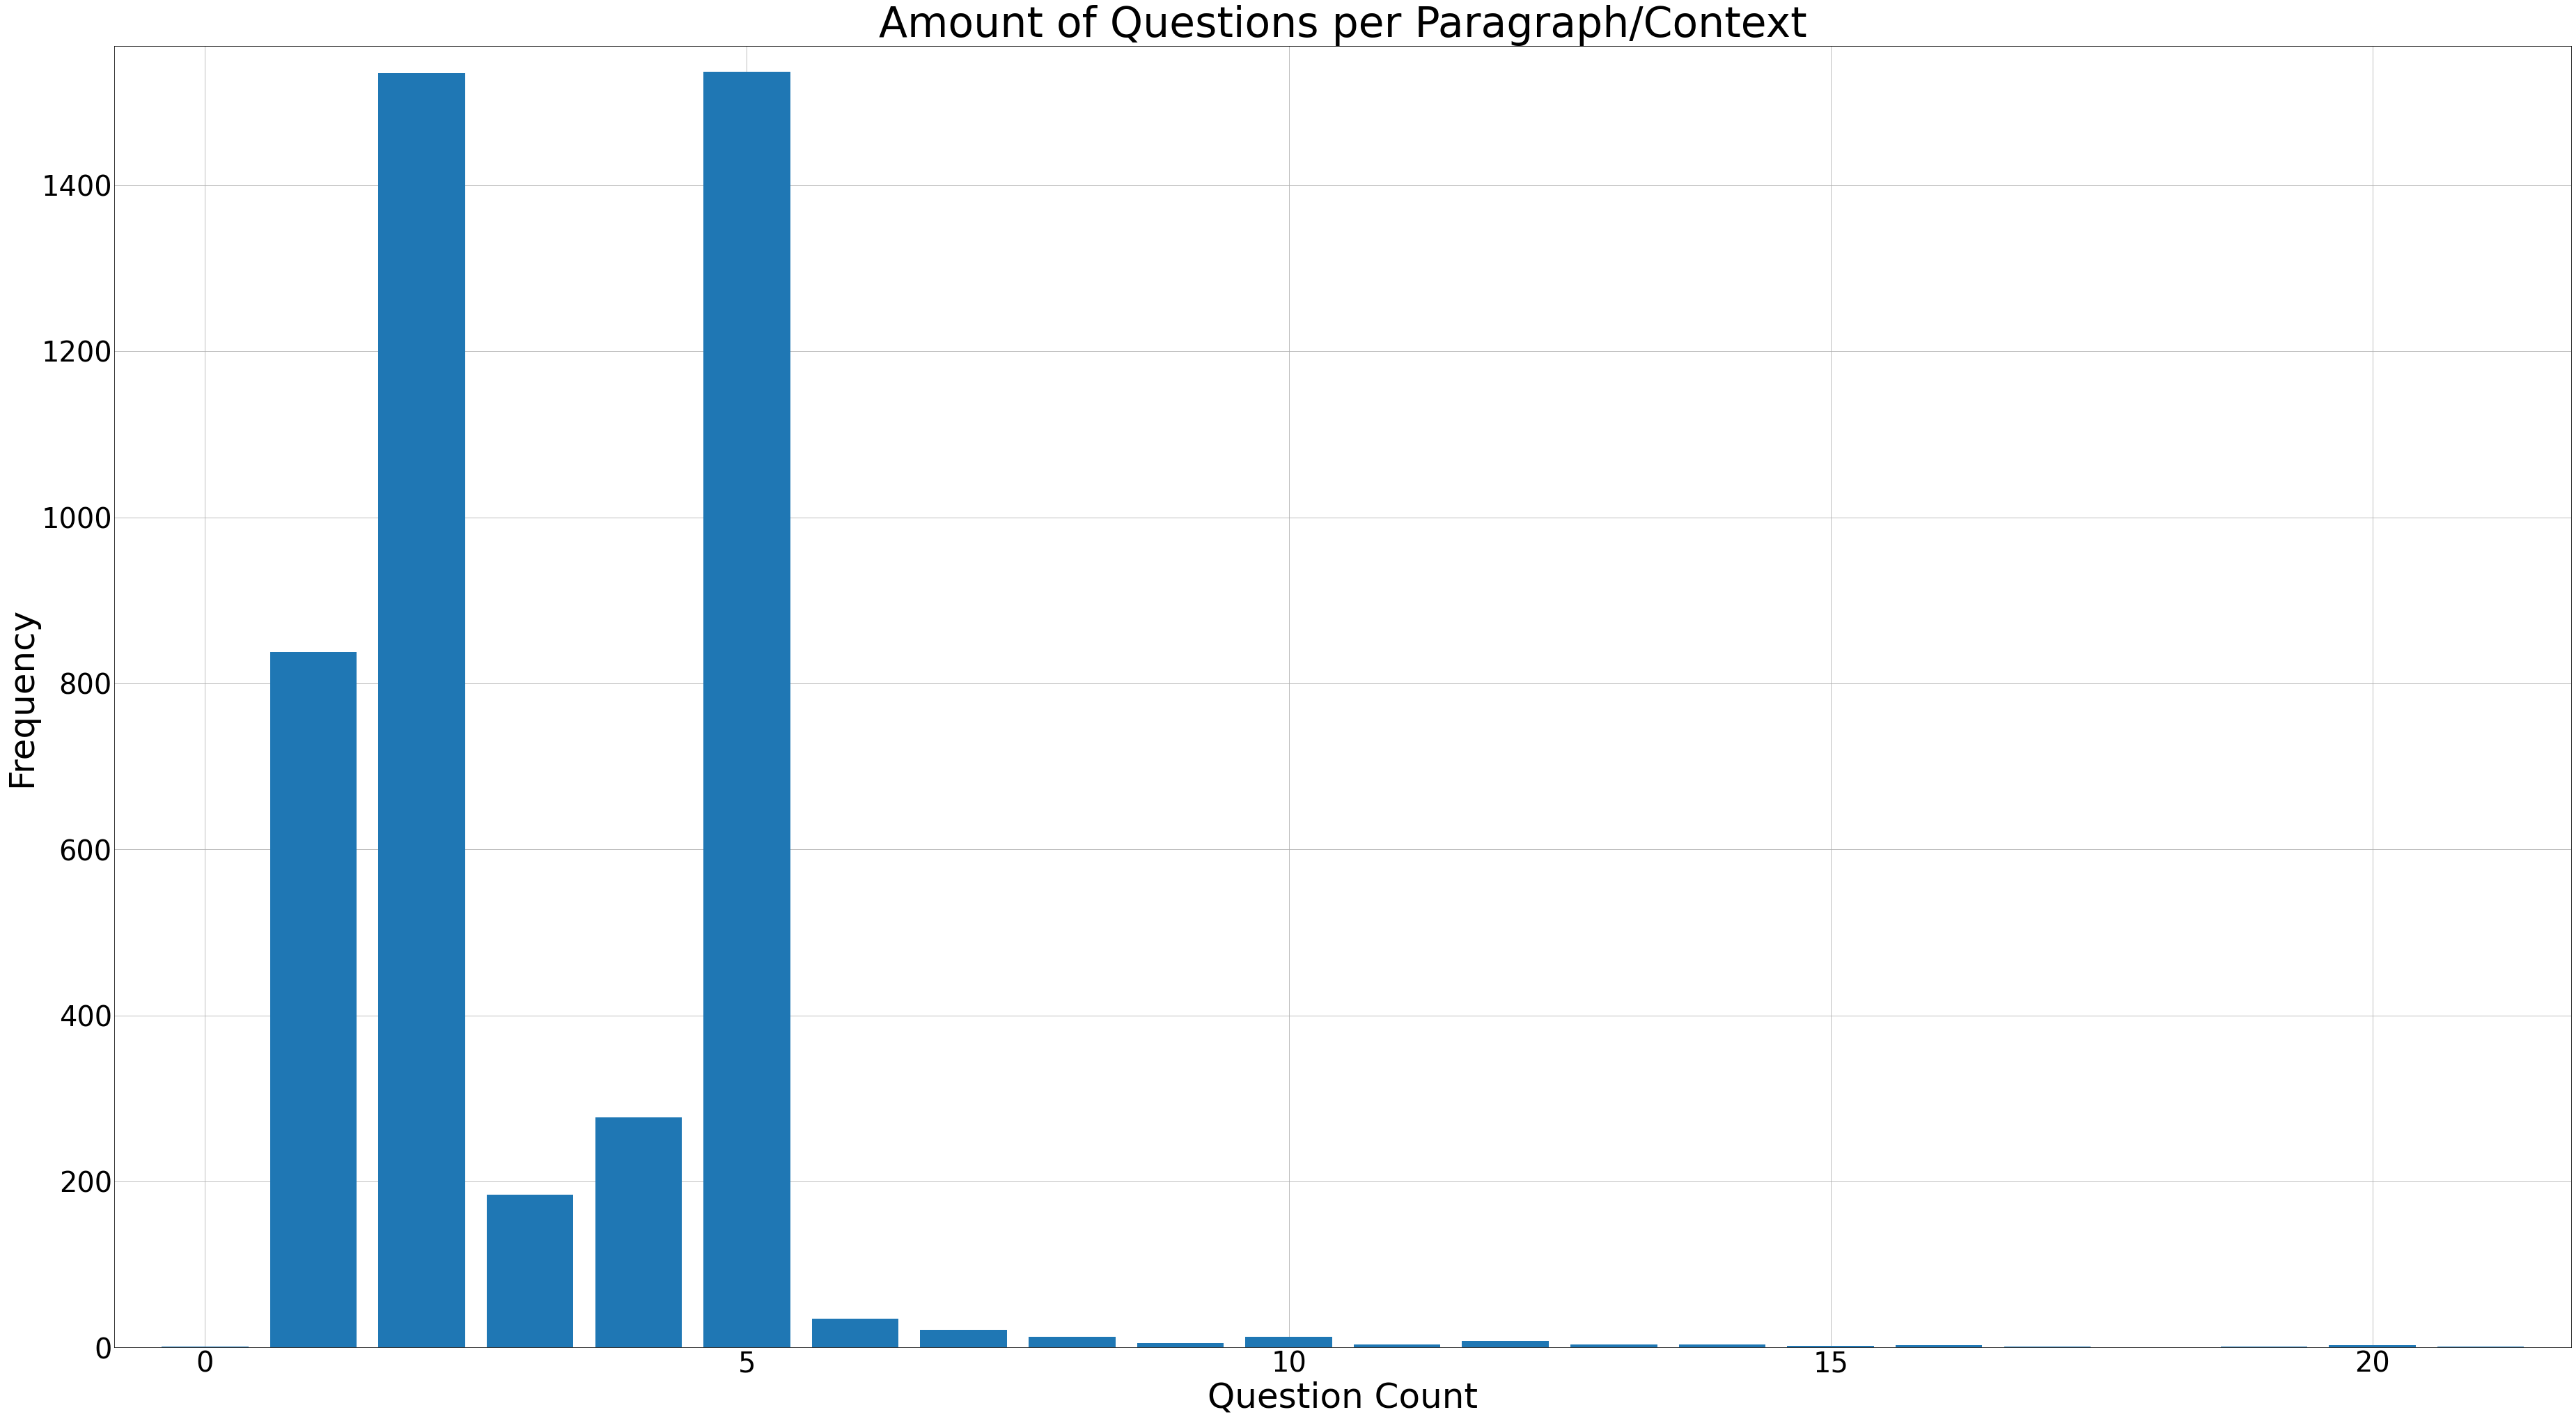

In [6]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
x_rating = dataframe["qas_length"].value_counts()
plt.xlabel('Question Count', fontsize=50)
plt.xticks(fontsize=40)
plt.ylabel('Frequency', fontsize=50)
plt.yticks(fontsize=40)
plt.bar(x_rating.index, x_rating.values)
plt.title('Amount of Questions per Paragraph/Context', fontsize=60)
plt.show()

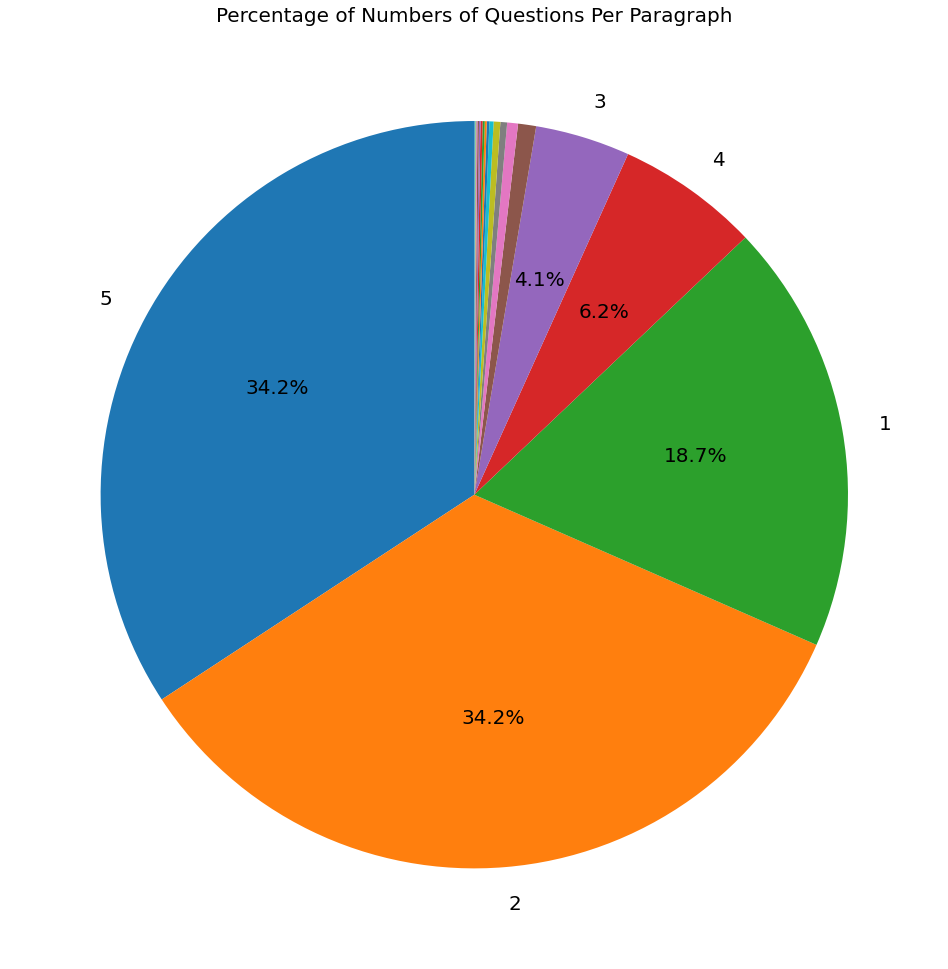

In [11]:
def my_autopct(pct):
    return ('%1.1f%%' % pct) if pct > 4 else ''

def get_new_labels(sizes, labels):
    new_labels = [label if size > 80 else '' for size, label in zip(sizes, labels)]
    return new_labels

plt.figure(figsize=(30,15))
plt.title('Percentage of Numbers of Questions Per Paragraph', fontsize=20)
sizes, labels = dataframe["qas_length"].value_counts().values, dataframe["qas_length"].value_counts().index.values
plt.pie(sizes, labels=get_new_labels(sizes, labels), autopct=my_autopct,startangle=90, textprops={'fontsize': 20})
plt.show()

According to our dataset and the two charts above, most of the paragraphs have **1-5 questions**. This means that our model would likely, perform well for tasks that it has to generate 1-5 questions.


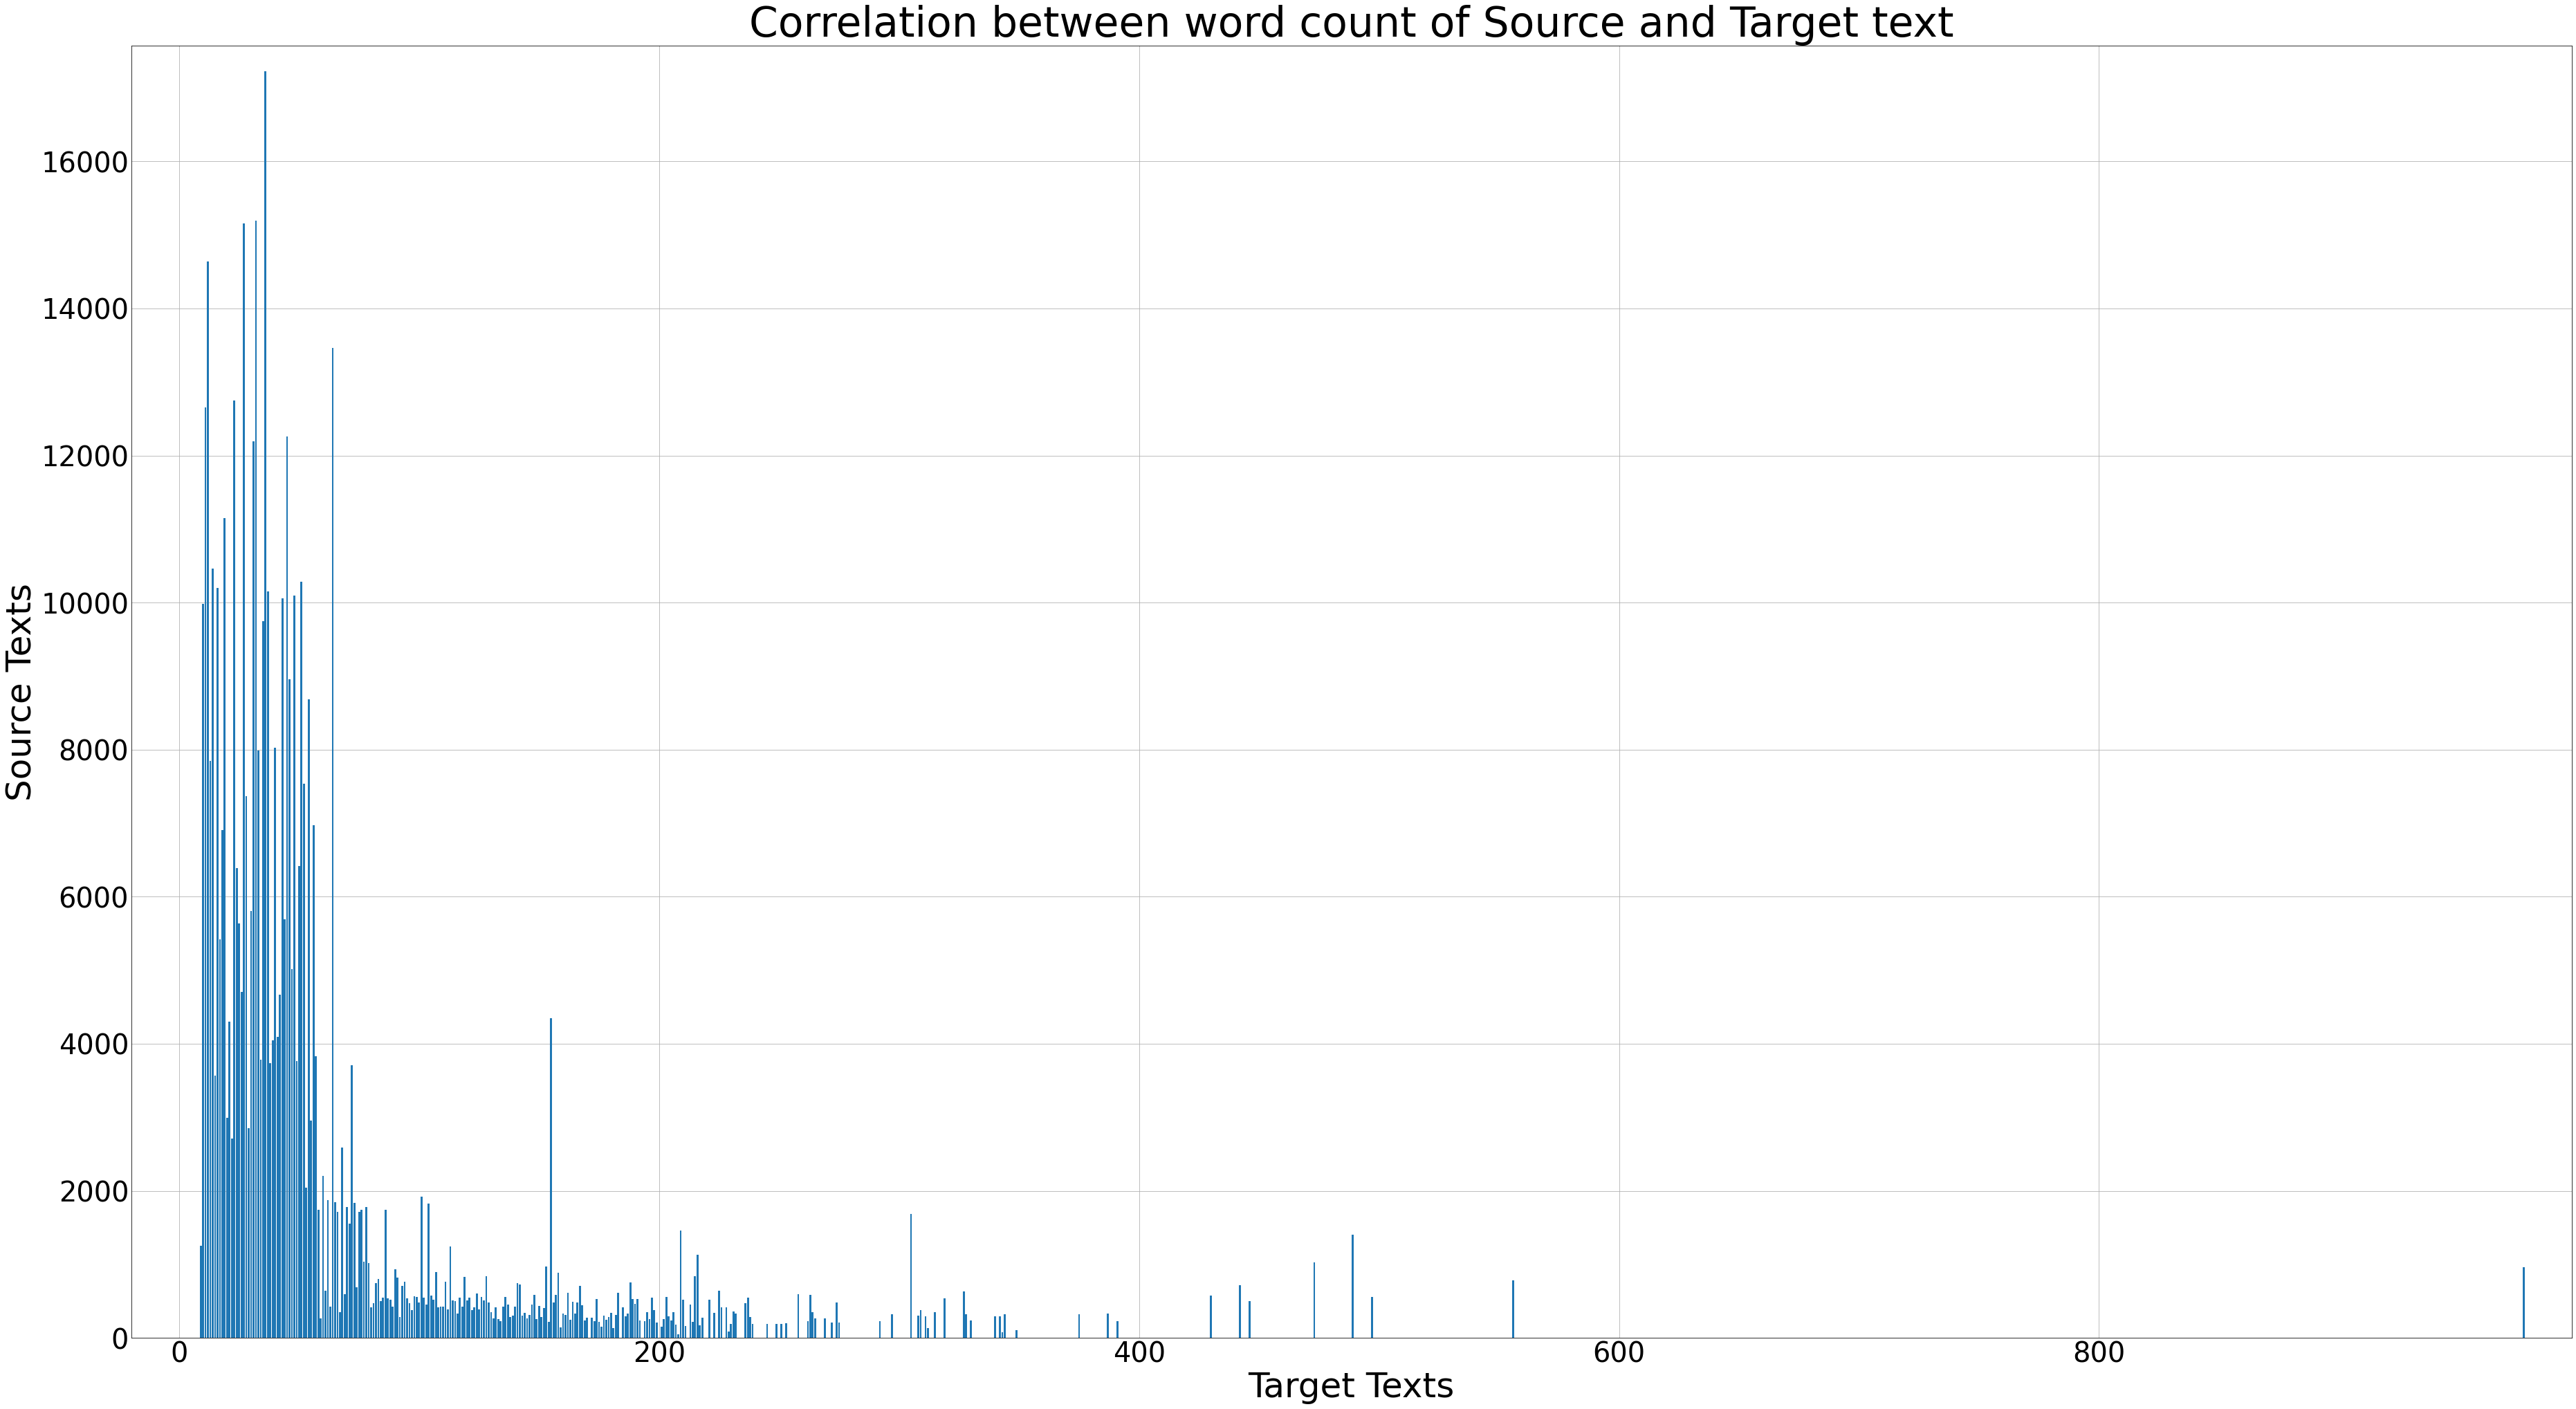

In [12]:
plt.figure(figsize=(50,30))
plt.margins(0.02)
plt.ylabel('Source Texts', fontsize=50)
plt.xticks(fontsize=40)
plt.xlabel('Target Texts', fontsize=50)
plt.yticks(fontsize=40)
plt.bar(dataframe["target_len"], dataframe["source_len"])
plt.title('Correlation between word count of Source and Target text', fontsize=60)
plt.show()

What we can infer from this chart on top is that longer word count in the context (`source text`) does not mean that the questions (`target_texts`) will be any longer. Statistically, it will probably be shorter. This may be beneficial to the model because it would learn to generate concise text.

In [13]:
all_words = []
for index, data in dataframe.iterrows():
    # Exclude the various "สร้าง n คำถาม:"
    source_tokenized = word_tokenize(data["source_text"], keep_whitespace=False)[4:]
    target_tokenized = word_tokenize(data["target_text"], keep_whitespace=False)
    all_words += source_tokenized + target_tokenized

commons = FreqDist(all_words).most_common(100)

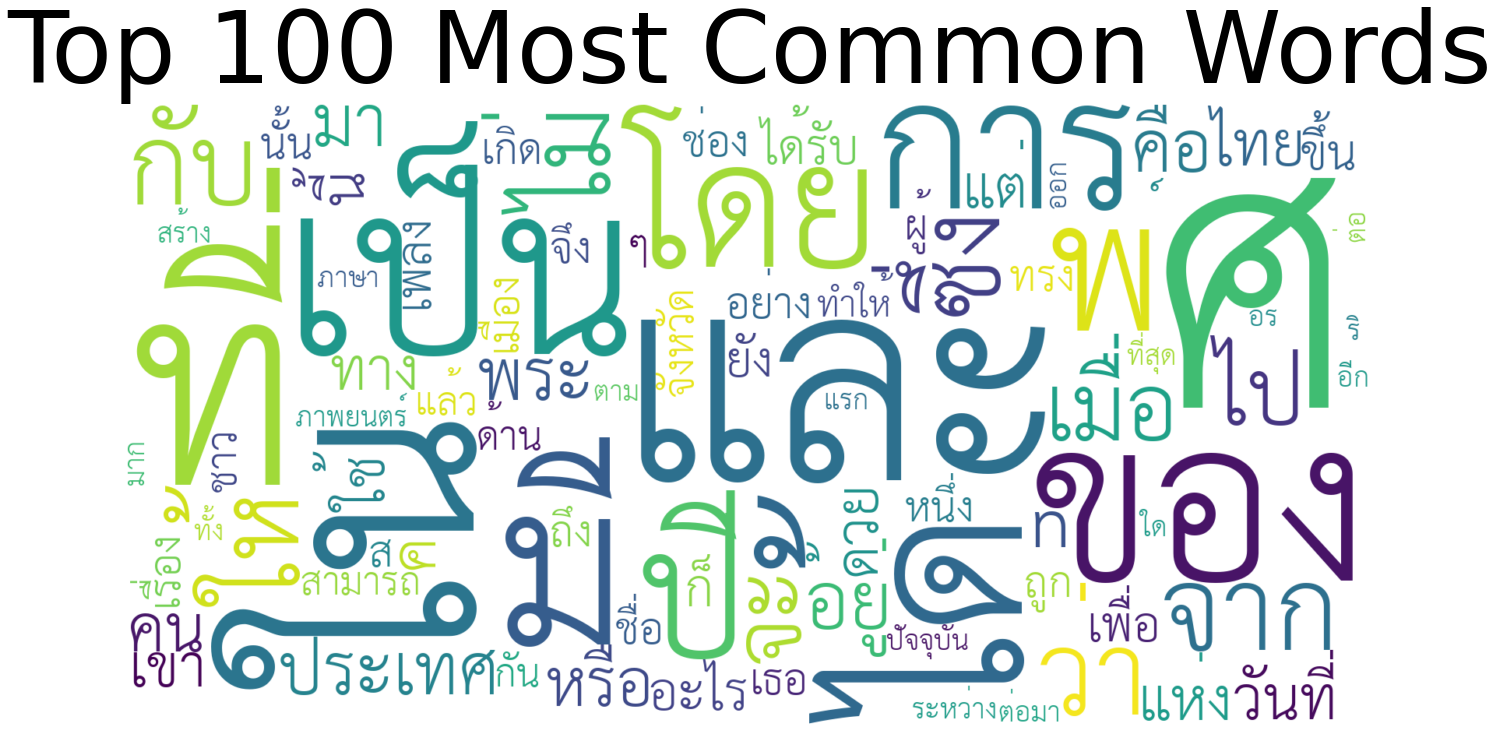

In [14]:
wordcloud = WordCloud(width=1600, height=800, background_color='white', font_path="/home/parin/Projects/QuestionGenerationT5/model/THSarabunNew.ttf", collocations=False, regexp=r"[\u0E00-\u0E7Fa-zA-Z']+").generate(str(commons).replace("'", ""))
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

From this *most common words* word cloud we can can gather that a good chunk of the dataset that we have has to do with Thailand. Furthermore, we can also infer that most of these relate to history/events because they have:

* ปี
* ที่
* วันที่
* สร้าง
* เมื่อ
* ใน
* โดย
* พระ
* ประเทศ

All, in all this **Exploratory Data Analysis** gave us some insightful information.

# Error Analysis

Inside this github directory, there is a file called "`default_test.json`". This file has the **source_text, predictions, and labels** of the **default** variant against the test set.


For error analysis I've broken it down into a few categories:

* Formatting Errors
    * Incomprehensible Generated Text (Wrong Grammar that makes the question not possible to understand)
    * No Answers in Generated Text
    * Wrong Amount of Questions
    * Repeating Questions


* Content Errors
    * Wrong Answers

Then, I slowly went through each of the lines in default_test.json one by one using the `error_analysis_helper.py` and recorded the results into `error_result.txt`. I've also visualized it into the charts below.

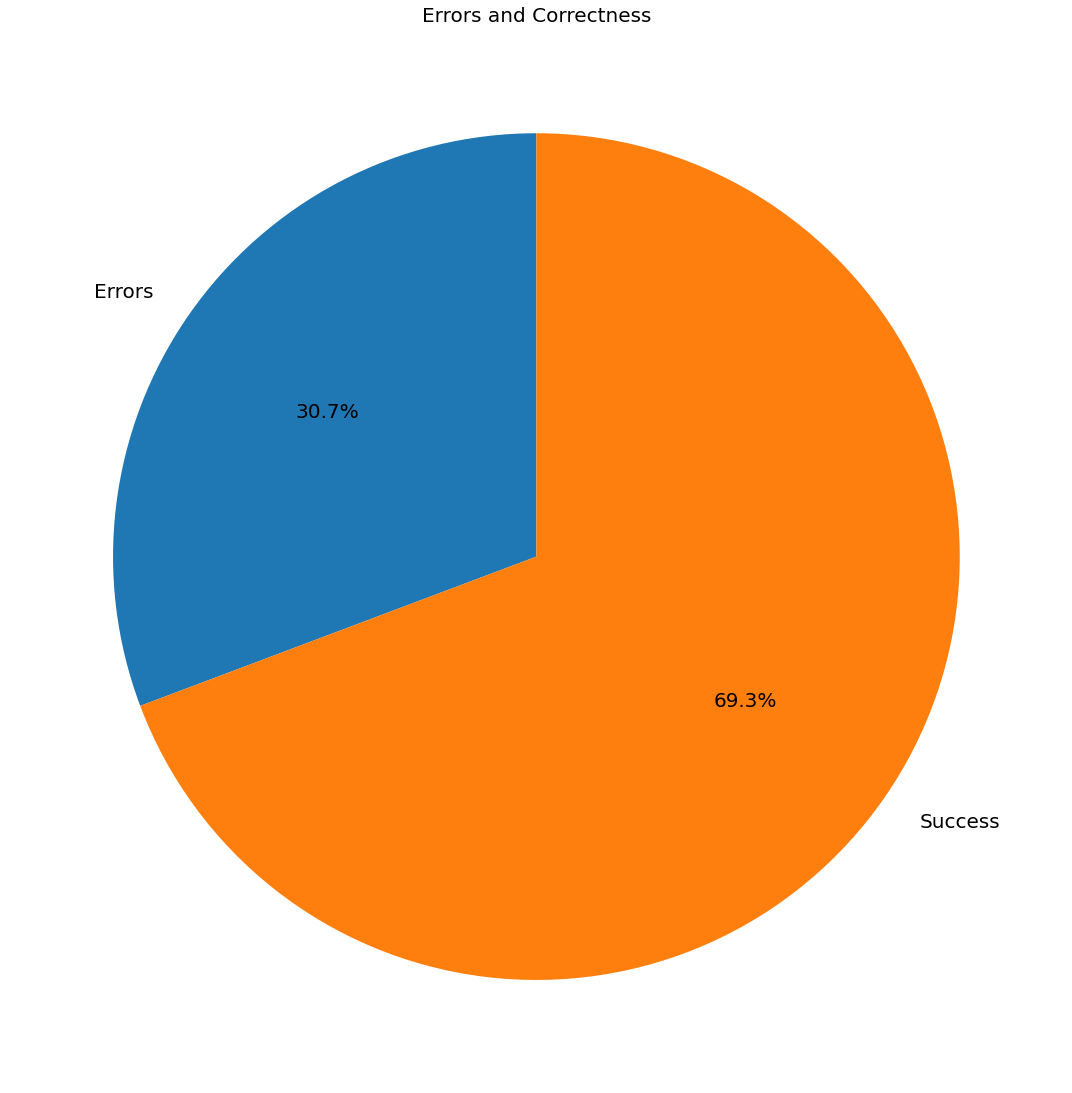

In [ ]:
error_total = 138
test_total = 449

plt.figure(figsize=(30,15))
plt.title('Errors and Correctness', fontsize=20)
plt.pie([138, test_total - error_total], labels=["Errors", "Success"], autopct="%1.1f%%", startangle=90, textprops={'fontsize': 20})
plt.show()

Below is a breakdown of the error types

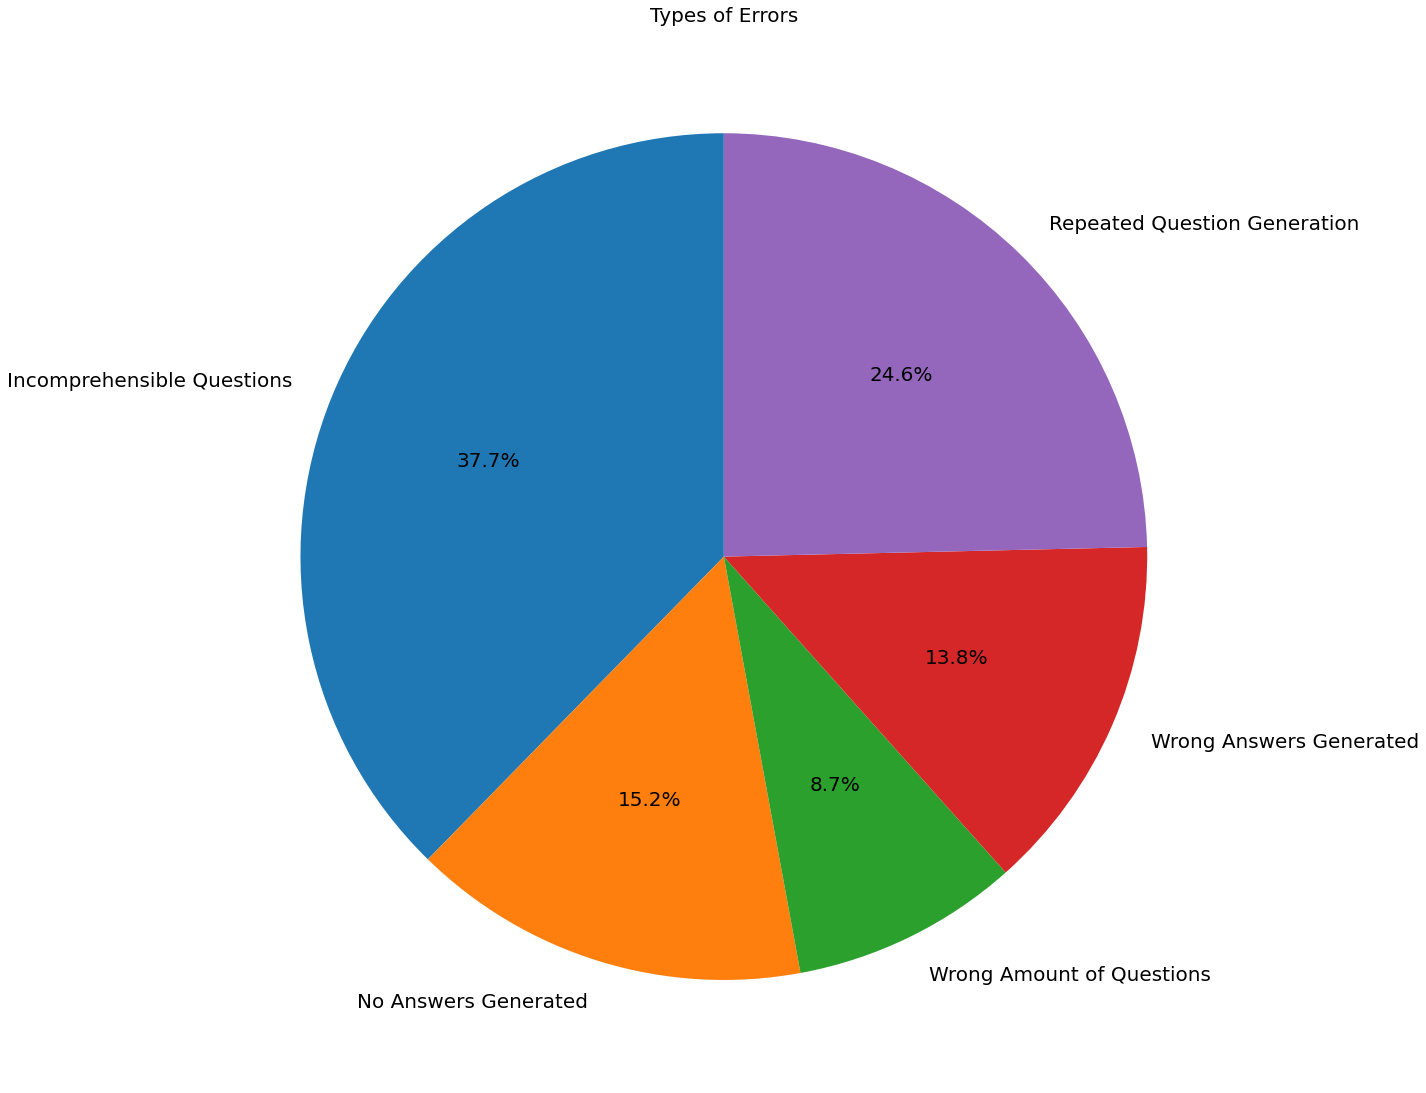

In [ ]:
plt.figure(figsize=(30,15))
plt.title('Types of Errors', fontsize=20)
plt.pie([52, 21, 12, 19, 34], labels=["Incomprehensible Questions", "No Answers Generated", "Wrong Amount of Questions", "Wrong Answers Generated", "Repeated Question Generation"], autopct="%1.1f%%", startangle=90, textprops={'fontsize': 20})
plt.show()